# 14장. 합성곱 신경망을 사용한 컴퓨터 비전

https://nbviewer.jupyter.org/github/rickiepark/handson-ml2/tree/master/

이 코드의 내용은 Hands-On Machine Learning with Scikit-Learn & TensorFlow을 참고했음을 밝힙니다.

In [2]:
import tensorflow as tf
from tensorflow import keras

# 시각 피질 구조

시각 피질 안의 많은 뉴런이 작은 국부 수용장(local receptive field)을 가진다는 것을 보였습니다. 즉 뉴런들이 시야의 일부 범위 안에 있는 시각 자극에만 반응한다는 뜻입니다. 뉴런의 수용장들은 서로 겹칠 수 있어서, 합치면 전체 시야를 감싸게 됩니다. 또한 어떤 뉴런은 수평선의 이미지에만 반응하고 반면 다른 뉴런은 다른 각도의 선분에 반응한다는 점을 보였습니다(두 뉴런은 동일한 수용장을 가지지만 다른 각도의 선분에 반응합니다). 또한 어떤 뉴런은 큰 수용장을 가져서 저수준 패턴이 조합된 더 복잡한 패턴에 반응한다는 것을 알았습니다.

*Note*<br>
왜 이미지 인식 문제에 일반적인 완전 연결 층의 심층 신경망을 사용하지 않을까요? 이런 신경망은 작은 이미지(예를 들면 MNIST)에서는 잘 작동하지만 큰 이미지에서는 아주 많은 파라미터가 만들어지기 때문에 문제가 됩니다. 예를 들어 100x100 이미지는 픽셀 10,000개로 이루어져 있습니다. 여기에 (다음 층으로 전달되는 정보의 양을 상당히 줄여서) 첫 번째 은닉층을 뉴런 1,000개로 만들어도 연결이 총 1천만 개가 생깁니다. 이는 첫 번째 은닉층일 뿐입니다. CNN은 부분적으로 연결하고 가중치를 공유하여 이 문제를 해결합니다.

# 합성곱 층

* convolutional layer: 합성곱 층의 뉴런은 입력 이미지(또는 피처 맵)의 모든 픽셀에 연결되는 것이 아니라 합성곱 층 뉴런의 수용장 안에 있는 픽셀에만 연결됩니다.
* zero padding: 높이와 너비를 이전 층과 같게 하기 위해 입럭의 주위에 0을 추가하는 것
* stride: 한 수용장과 다음 수용장 사이의 간격
* filter(convolutional kernel): 가중치 세트. 층의 전체 뉴런에 적용된 하나의 필터는 하나의 특성 맵(feature map)을 생성

<img src='https://i.imgur.com/Wmnykgt.png' width='100%'>

Reference) https://m.blog.naver.com/seongcheol02/221746849767

*Note*<br>
한 특성 맵에 있는 모든 뉴런이 갘은 파라미터를 공유한다는 사실은 모델의 전체 파라미터 수를 급격하게 줄여줍니다. 일단 CNN이 한 지점에서 패턴을 인식하도록 학습되었다면 다른 어느 위치에 있는 패턴도 인식할 수 있습니다. 반대로 일반적인 DNN은 한 지점에 있는 패턴을 인식하도록 학습되었다면 오직 패턴이 그 위치에 있을 때만 감지할 수 있습니다.

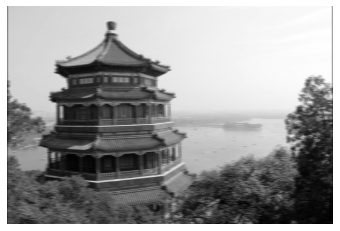

In [4]:
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

* images는 입력의 미니배치(4D 텐서)입니다.
* filers는 적용된 일련의 필터(4D 텐서)입니다.
* strides는 1이나 4개의 원소를 갖는 1D 배열로 지정할 수 있습니다. 1D 배열의 가운데 두 개의 원소는 수직, 수평 스트라이드(s_h와 s_w)이고, 현재는 첫 번째와 마지막 원소가 1이어야 합니다. 언젠가 배치 스트라이드(즉, 일부 샘플을 건너뛰기 위해)와 채널 스트라이드(이전 층의 특성 맵이나 채널을 건너뛰기 위해)를 지정하는 데 사용될지도 모릅니다.
* padding은 'VALID'와 'SAME' 중 하나를 지정합니다. 'VALID'로 지정하면 합성곱 층에 제로 패딩을 사용하지 않습니다. 스크라이드에 따라 입력 이미지의 아래와 오른쪽 행과 열이 무시될 수 있습니다(간단하게 표현하기 위해서 여기서는 수평 차원만 나타냈지만 갘은 로직이 수직 차원에도 적용됩니다). 이는 모든 뉴런의 수용장이 입력 안쪽 영역에만 놓인다는 의미입니다(경계 밖으로 나가지 않습니다). 그래서 이름이 VALID입니다.
* 551~